In [1]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import PIL
from tensorflow.keras import layers
from tensorflow import keras
import time

from IPython import display
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/independent_project/

/content/drive/MyDrive/independent_project


## Create doublemoon dataset

In [ ]:
def gen_moons(n_instance):
    noise = 0.05

    input, ignore = datasets.make_moons(n_samples=n_instance, noise=noise)

    X = input[:,0].reshape(-1,1)
    y = input[:,1].reshape(-1,1)

    return X, y

In [ ]:
n_instance = 1000
X_train, y_train = gen_moons(n_instance)

In [ ]:
def export_dataset(data, name):
  dataset = pd.DataFrame(data)
  dataset.to_excel(name + '.xlsx',index=False)

In [ ]:
export_dataset(X_train, 'dataset/moons_X_train')
export_dataset(y_train, 'dataset/moons_y_train')

## Import doublemoon dataset

In [4]:
def import_dataset(name):
    data = pd.read_excel(name + '.xlsx')
    return data.iloc[:,:].values

In [5]:
X_train = import_dataset('dataset/moons_X_train')
y_train = import_dataset('dataset/moons_y_train')

In [6]:
tf.random.set_seed(32)

## Preprocess

In [72]:
BATCH_SIZE = 100
latent_space = 3
train_dataset = np.concatenate((X_train, y_train), axis=1)

(1000, 2)


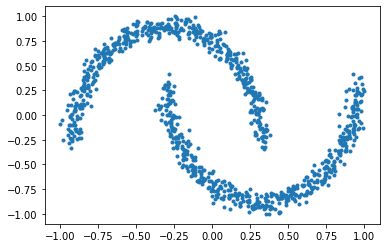

In [73]:
scaler = MinMaxScaler((-1,1))
train_dataset = scaler.fit_transform(train_dataset)
print(train_dataset.shape)
plt.plot(train_dataset[:,0],train_dataset[:,1],'.' )

In [74]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(BATCH_SIZE)
# for data in train_dataset:
#     print(data)
#     break

## Architecture

In [75]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4, use_bias=False, input_shape=(latent_space,)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Reshape((4, 4)))
    
    model.add(layers.Conv1DTranspose(16, kernel_size=1, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv1DTranspose(8, kernel_size=1, strides=1, padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Flatten()) 
    model.add(layers.Dense(2, use_bias=False, activation='tanh'))
    return model

In [76]:
generator = make_generator_model()
generator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 16)                48        
_________________________________________________________________
batch_normalization_24 (Batc (None, 16)                64        
_________________________________________________________________
re_lu_12 (ReLU)              (None, 16)                0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 4, 4)              0         
_________________________________________________________________
conv1d_transpose_8 (Conv1DTr (None, 4, 16)             64        
_________________________________________________________________
batch_normalization_25 (Batc (None, 4, 16)             64        
_________________________________________________________________
re_lu_13 (ReLU)              (None, 4, 16)           

In [77]:
noise = tf.random.normal([1000, latent_space])
generated_image = generator(noise, training=False)
# print(generated_image.shape)
# plt.plot(generated_image[:,0], generated_image[:,1],'.')

In [78]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4, use_bias=False, input_shape=([2])))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((4, 4)))
    
    model.add(layers.Conv1D(16, kernel_size=1, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv1D(8, kernel_size=1, strides=1, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [79]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 16)                32        
_________________________________________________________________
batch_normalization_27 (Batc (None, 16)                64        
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16)                0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 4, 4)              0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 4, 16)             80        
_________________________________________________________________
batch_normalization_28 (Batc (None, 4, 16)             64        
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 4, 16)           

In [80]:
# decision = discriminator(generated_image)
# print (decision)

## Train

In [81]:
gan = keras.models.Sequential([generator, discriminator])

In [82]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)
discriminator_mean_loss = tf.keras.metrics.Mean(dtype=tf.float32)

In [83]:
# The discriminator and the generator optimizers are different since we will train two networks separately.
generator_optimizer = tf.keras.optimizers.Adam(2e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [84]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(batch):
    noise = tf.random.normal([BATCH_SIZE, latent_space])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(batch, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    generator_mean_loss(gen_loss)
    discriminator_mean_loss(disc_loss)

In [85]:
def train(dataset, epochs):
    hist = []
    for epoch in range(epochs):
        start = time.time()
        print("Epoch {}/{}".format(epoch + 1, epochs))   

        for batch in dataset:
            train_step(batch)
        
        hist.append([generator_mean_loss.result().numpy(), discriminator_mean_loss.result().numpy()])

        generator_mean_loss.reset_states()
        discriminator_mean_loss.reset_states()

        if epoch%100 == 0: 
            generated_image = generator(noise, training=False)
            #print(generated_image.shape)
            plt.plot(generated_image[:,0], generated_image[:,1],'.')
  
            # Save model
            # gan.save('ganmodels/'+notebookName[:-6]+str(epoch)+'.h5')    
            
            # plot loss
            print('Loss: ')
            fig, ax = plt.subplots(1,1, figsize=[20,10])
            ax.plot(hist)
            ax.legend(['loss_gen', 'loss_disc'])
            ax.set_yscale('log')
            ax.grid()
            plt.show()
            
    return hist

In [86]:
hist = train(train_dataset, epochs=2000)

Output hidden; open in https://colab.research.google.com to view.

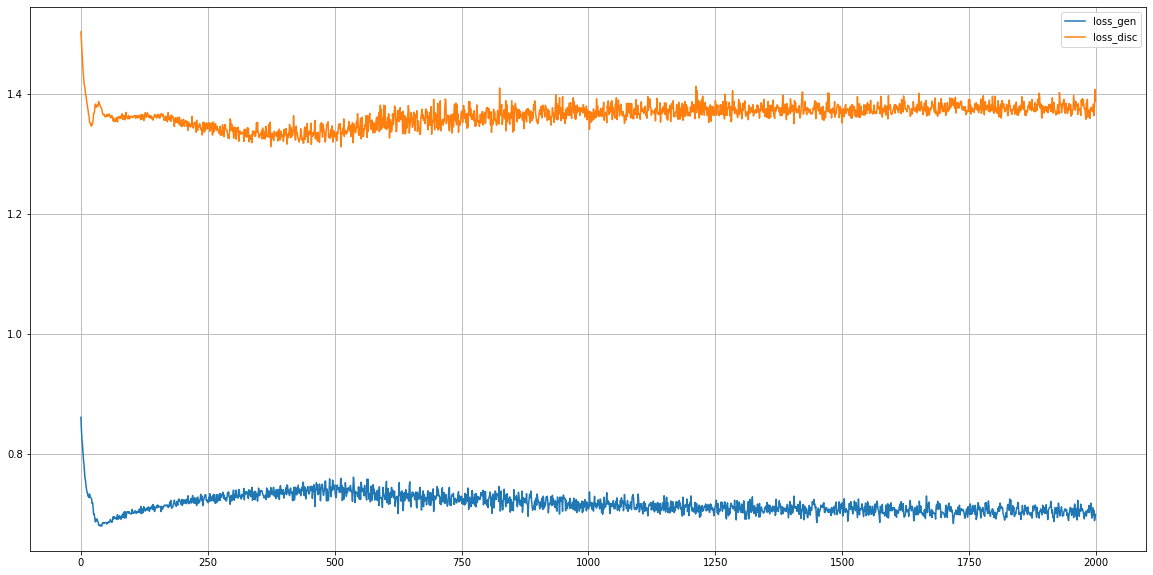

In [87]:
fig, ax = plt.subplots(1,1, figsize=[20,10])
ax.plot(hist)
ax.legend(['loss_gen', 'loss_disc'])
#ax.set_yscale('log')
ax.grid()

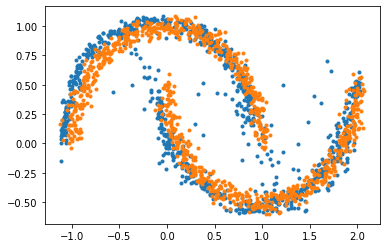

In [88]:
generated_image = generator(noise, training=False)
#print(generated_image.shape)
generated_image = scaler.inverse_transform(generated_image)
plt.plot(generated_image[:,0], generated_image[:,1],'.')
plt.plot(X_train, y_train, '.')

In [89]:
x_num = 100
y_num = 100
x = np.linspace(start=-1, stop=1, num=x_num)
y = np.linspace(start=-1, stop=1, num=y_num)

In [90]:
xy = np.zeros((x_num*y_num,2))
for i in range(x_num):
    for j in range(y_num):
        xy[i*y_num+j][0] = x[i]
        xy[i*y_num+j][1] = y[j]

In [91]:
disc_output = discriminator(xy)
disc_output = disc_output.numpy().reshape(x_num,y_num).T

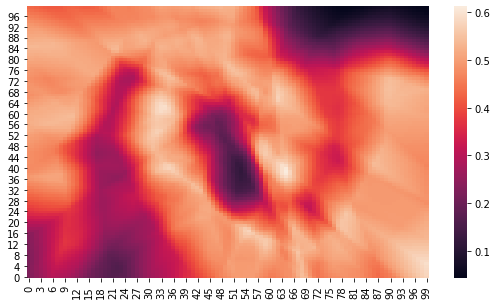

In [92]:
fig, ax = plt.subplots(1,1, figsize=(9,5))
sns.heatmap(disc_output, ax=ax)
ax.invert_yaxis()

Predict Fixed Input

In [ ]:
# latent_values = tf.random.normal([500, latent_space])
# predicted_values = generator.predict(latent_values)

In [ ]:
# plt.plot(predicted_values[:,0], predicted_values[:,1],'.')
# plt.plot(X_train, y_train, '.')

In [119]:
num_fixed = 9
x_input = np.linspace(-1,1,num_fixed)
n_features = 2
num = 50
n_points = num_fixed * num

In [120]:
predict_all = np.ndarray((n_points, n_features))

for i in range(num_fixed):
    predicted = np.full((n_points//9, n_features), x_input[i])
    predict_all[i*num:i*num+num, :] = predicted[:,:]

input = predict_all.reshape(n_points, n_features).astype('float32')

In [121]:
optimizer = tf.keras.optimizers.Adam(1e-2)

In [122]:
def mse_loss(inp, outp):
    inp = tf.reshape(inp, [-1, n_features])
    outp = tf.reshape(outp, [-1, n_features])
    
    return tf.reduce_mean(tf.math.squared_difference(inp[:,0], outp[:,0]))

In [123]:
@tf.function
def opt_step(latent_values, real_coding):
    with tf.GradientTape() as tape:
        tape.watch(latent_values)
        gen_output = generator(latent_values, training=False)
        loss = mse_loss(real_coding, gen_output)

    gradient = tape.gradient(loss, latent_values)
    optimizer.apply_gradients(zip([gradient], [latent_values]))

    return loss

In [124]:
def optimize_coding(real_coding):
    latent_values = tf.random.normal([len(real_coding), latent_space])
    latent_values = tf.Variable(latent_values)
    
    loss = []
    for epoch in range(10000):
        loss.append(opt_step(latent_values, real_coding).numpy())
        
    plt.plot(loss)
    #plt.grid()
    plt.show
        
    return latent_values

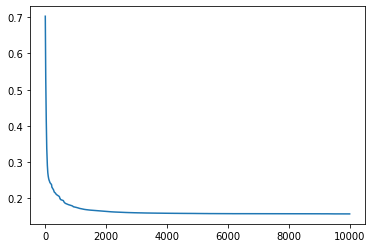

In [ ]:
latent_values = optimize_coding(input)

predicted_vals = generator.predict(tf.convert_to_tensor(latent_values)).reshape(len(input), n_features)
predicted_vals = predicted_vals.reshape(len(input), n_features)

X_generated = predicted_vals[0:,:]

In [ ]:
for i in range(9):
    X_generated[i*num:(i+1)*num-1,0] = x_input[i]

In [ ]:
X_generated = scaler.inverse_transform(X_generated)

Generated Data: (450, 2)


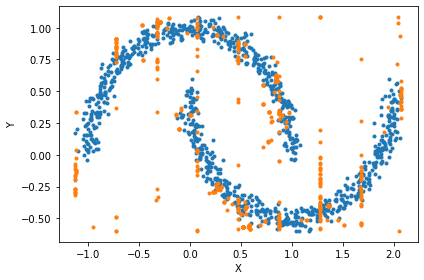

In [ ]:
print("Generated Data:",X_generated.shape)
plt.plot(X_train, y_train,'.')
plt.plot(X_generated[:,0],X_generated[:,1],'.')
plt.ylabel('Y')
plt.xlabel('X')
plt.tight_layout()